In [ ]:
%%capture 
!pip install transformers
!pip install datasets
!pip install --upgrade accelerate

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

from pathlib import Path
import ast

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from datasets import Dataset,DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from transformers import TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch

In [ ]:
class config:
  BASE_DIR = Path("/content/drive/MyDrive/DataColab Task")
  DATA_DIR = BASE_DIR / "data"
  MODEL_DIR = BASE_DIR / "models"

In [ ]:
pd.set_option("display.max_colwidth", None)
df = pd.read_csv(config.DATA_DIR / "stories.csv")
df.head(6)

,body,topic
0,,['39822b5f-e37e-43e8-b997-7142fe55c3ea']
1,,['0d817400-3f5d-41e0-929c-c31fdbe75d31']
2,,['83a09c6b-5f2f-421f-ae50-b38acca7e008']
3,,['6fbf954a-03f9-4782-a65f-783271c9c447']
4,"hello and welcome to BBC News a woman who gave key evidence in the trial of Gillen Maxwell has spoken publicly today saying she hopes the guilty verdict will bring some solace to other survivors Annie Farmer, the only witness to use her real name during testimony said the case demonstrated that no one was above the law Maxwell was found guilty yesterday by a jury New York of grooming underage girls to be abused by her friend Jeffrey Epstein her lawyers say they'll appeal against the","['83a09c6b-5f2f-421f-ae50-b38acca7e008', '9ff54ded-904b-4e0c-85ce-a3617f5cb913']"
5,,['83a09c6b-5f2f-421f-ae50-b38acca7e008']


In [ ]:
df.shape

(5181, 2)

In [ ]:
df.isna().sum()

body     0
topic    0
dtype: int64

In [ ]:
(df["body"] == " ").sum()

29

In [ ]:
#removing rows with no body
df.drop(df.loc[df["body"] == " "].index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(3)

,body,topic
0,"hello and welcome to BBC News a woman who gave key evidence in the trial of Gillen Maxwell has spoken publicly today saying she hopes the guilty verdict will bring some solace to other survivors Annie Farmer, the only witness to use her real name during testimony said the case demonstrated that no one was above the law Maxwell was found guilty yesterday by a jury New York of grooming underage girls to be abused by her friend Jeffrey Epstein her lawyers say they'll appeal against the","['83a09c6b-5f2f-421f-ae50-b38acca7e008', '9ff54ded-904b-4e0c-85ce-a3617f5cb913']"
1,"news now out of North Hollywood. A 14 yearold girl was found dead inside a dressing room after police fired at a suspect. It happened at a Burlington store Thursday morning. Los Angeles police first responded to an assault call. Police shot at the suspect, who died. Behind him was a dressing room where the teen was hit by a bullet. The assault victim was injured and taken to a hospital today. A jury",['9ff54ded-904b-4e0c-85ce-a3617f5cb913']
2,"homelessness his city's greatest failure. That was his message in tonight's State of the City address. As of the 2019 homeless count, San Jose had more than 60 unhoused residents in the city over the last year. Santa Clara County's Supportive Housing Network provided permanent housing to nearly 5000 people. The number of new unhoused residents declined by 29%. That's all according to our media partner, the Mercury News. Even so, Mayor Lacardo says there's much more work to be done in the Silicon Valley spirit","['83a09c6b-5f2f-421f-ae50-b38acca7e008', '74e2fab8-689f-4e17-9a1c-e1f92e084f55', '6fbf954a-03f9-4782-a65f-783271c9c447']"


In [ ]:
(df["body"] == " ").sum()

0

In [ ]:
(df["topic"] == " ").sum()

0

In [ ]:
#turning topics column values from string to list (gets stored as an object in dataframe)
df["topic"] = df["topic"].apply(lambda row: ast.literal_eval(row))
df.head(3)

,body,topic
0,"hello and welcome to BBC News a woman who gave key evidence in the trial of Gillen Maxwell has spoken publicly today saying she hopes the guilty verdict will bring some solace to other survivors Annie Farmer, the only witness to use her real name during testimony said the case demonstrated that no one was above the law Maxwell was found guilty yesterday by a jury New York of grooming underage girls to be abused by her friend Jeffrey Epstein her lawyers say they'll appeal against the","[83a09c6b-5f2f-421f-ae50-b38acca7e008, 9ff54ded-904b-4e0c-85ce-a3617f5cb913]"
1,"news now out of North Hollywood. A 14 yearold girl was found dead inside a dressing room after police fired at a suspect. It happened at a Burlington store Thursday morning. Los Angeles police first responded to an assault call. Police shot at the suspect, who died. Behind him was a dressing room where the teen was hit by a bullet. The assault victim was injured and taken to a hospital today. A jury",[9ff54ded-904b-4e0c-85ce-a3617f5cb913]
2,"homelessness his city's greatest failure. That was his message in tonight's State of the City address. As of the 2019 homeless count, San Jose had more than 60 unhoused residents in the city over the last year. Santa Clara County's Supportive Housing Network provided permanent housing to nearly 5000 people. The number of new unhoused residents declined by 29%. That's all according to our media partner, the Mercury News. Even so, Mayor Lacardo says there's much more work to be done in the Silicon Valley spirit","[83a09c6b-5f2f-421f-ae50-b38acca7e008, 74e2fab8-689f-4e17-9a1c-e1f92e084f55, 6fbf954a-03f9-4782-a65f-783271c9c447]"


In [ ]:
#finding all unique topics
topics = set()
df["topic"].apply(lambda row: topics.update(row))
topics

{'0d817400-3f5d-41e0-929c-c31fdbe75d31',
 '39822b5f-e37e-43e8-b997-7142fe55c3ea',
 '6fbf954a-03f9-4782-a65f-783271c9c447',
 '74e2fab8-689f-4e17-9a1c-e1f92e084f55',
 '83a09c6b-5f2f-421f-ae50-b38acca7e008',
 '96326734-fd82-4350-b45c-513e7eb9147c',
 '9a06646a-e1df-4fca-888e-69658420556b',
 '9ff54ded-904b-4e0c-85ce-a3617f5cb913',
 'a58b4b70-1b59-4240-917d-a2165a0ce2f0',
 'aa1edc37-1a01-414a-bcf7-8517e7c7053d',
 'b49207eb-96eb-4b73-b534-adc0ef85022a',
 'ca197b81-ca86-4792-8c25-2ba7cd4195b5',
 'e7cbe38d-c987-4113-aa94-fd77eda451d5',
 'ebf2991e-4b7d-44c6-927b-a261a7b21d2c',
 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa'}

In [ ]:
len(topics)

15

In [ ]:
#one hot encoding the topics using scikit-learn's MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
ohe_df = pd.DataFrame(one_hot.fit_transform(df["topic"]), columns=list(topics))
ohe_df.head()

,0d817400-3f5d-41e0-929c-c31fdbe75d31,39822b5f-e37e-43e8-b997-7142fe55c3ea,ca197b81-ca86-4792-8c25-2ba7cd4195b5,b49207eb-96eb-4b73-b534-adc0ef85022a,6fbf954a-03f9-4782-a65f-783271c9c447,9ff54ded-904b-4e0c-85ce-a3617f5cb913,74e2fab8-689f-4e17-9a1c-e1f92e084f55,9a06646a-e1df-4fca-888e-69658420556b,96326734-fd82-4350-b45c-513e7eb9147c,f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa,e7cbe38d-c987-4113-aa94-fd77eda451d5,aa1edc37-1a01-414a-bcf7-8517e7c7053d,ebf2991e-4b7d-44c6-927b-a261a7b21d2c,a58b4b70-1b59-4240-917d-a2165a0ce2f0,83a09c6b-5f2f-421f-ae50-b38acca7e008
0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0


In [ ]:
ohe_df.iloc[0]

0d817400-3f5d-41e0-929c-c31fdbe75d31    0
39822b5f-e37e-43e8-b997-7142fe55c3ea    0
ca197b81-ca86-4792-8c25-2ba7cd4195b5    0
b49207eb-96eb-4b73-b534-adc0ef85022a    0
6fbf954a-03f9-4782-a65f-783271c9c447    1
9ff54ded-904b-4e0c-85ce-a3617f5cb913    0
74e2fab8-689f-4e17-9a1c-e1f92e084f55    0
9a06646a-e1df-4fca-888e-69658420556b    1
96326734-fd82-4350-b45c-513e7eb9147c    0
f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa    0
e7cbe38d-c987-4113-aa94-fd77eda451d5    0
aa1edc37-1a01-414a-bcf7-8517e7c7053d    0
ebf2991e-4b7d-44c6-927b-a261a7b21d2c    0
a58b4b70-1b59-4240-917d-a2165a0ce2f0    0
83a09c6b-5f2f-421f-ae50-b38acca7e008    0
Name: 0, dtype: int64

In [ ]:
one_hot.classes_

array(['0d817400-3f5d-41e0-929c-c31fdbe75d31',
       '39822b5f-e37e-43e8-b997-7142fe55c3ea',
       '6fbf954a-03f9-4782-a65f-783271c9c447',
       '74e2fab8-689f-4e17-9a1c-e1f92e084f55',
       '83a09c6b-5f2f-421f-ae50-b38acca7e008',
       '96326734-fd82-4350-b45c-513e7eb9147c',
       '9a06646a-e1df-4fca-888e-69658420556b',
       '9ff54ded-904b-4e0c-85ce-a3617f5cb913',
       'a58b4b70-1b59-4240-917d-a2165a0ce2f0',
       'aa1edc37-1a01-414a-bcf7-8517e7c7053d',
       'b49207eb-96eb-4b73-b534-adc0ef85022a',
       'ca197b81-ca86-4792-8c25-2ba7cd4195b5',
       'e7cbe38d-c987-4113-aa94-fd77eda451d5',
       'ebf2991e-4b7d-44c6-927b-a261a7b21d2c',
       'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa'], dtype=object)

In [ ]:
df.loc[0, "topic"]

['83a09c6b-5f2f-421f-ae50-b38acca7e008',
 '9ff54ded-904b-4e0c-85ce-a3617f5cb913']

In [ ]:
data = pd.concat([df, ohe_df], axis=1)
data.head(3)

,body,topic,0d817400-3f5d-41e0-929c-c31fdbe75d31,39822b5f-e37e-43e8-b997-7142fe55c3ea,ca197b81-ca86-4792-8c25-2ba7cd4195b5,b49207eb-96eb-4b73-b534-adc0ef85022a,6fbf954a-03f9-4782-a65f-783271c9c447,9ff54ded-904b-4e0c-85ce-a3617f5cb913,74e2fab8-689f-4e17-9a1c-e1f92e084f55,9a06646a-e1df-4fca-888e-69658420556b,96326734-fd82-4350-b45c-513e7eb9147c,f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa,e7cbe38d-c987-4113-aa94-fd77eda451d5,aa1edc37-1a01-414a-bcf7-8517e7c7053d,ebf2991e-4b7d-44c6-927b-a261a7b21d2c,a58b4b70-1b59-4240-917d-a2165a0ce2f0,83a09c6b-5f2f-421f-ae50-b38acca7e008
0,"hello and welcome to BBC News a woman who gave key evidence in the trial of Gillen Maxwell has spoken publicly today saying she hopes the guilty verdict will bring some solace to other survivors Annie Farmer, the only witness to use her real name during testimony said the case demonstrated that no one was above the law Maxwell was found guilty yesterday by a jury New York of grooming underage girls to be abused by her friend Jeffrey Epstein her lawyers say they'll appeal against the","[83a09c6b-5f2f-421f-ae50-b38acca7e008, 9ff54ded-904b-4e0c-85ce-a3617f5cb913]",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,"news now out of North Hollywood. A 14 yearold girl was found dead inside a dressing room after police fired at a suspect. It happened at a Burlington store Thursday morning. Los Angeles police first responded to an assault call. Police shot at the suspect, who died. Behind him was a dressing room where the teen was hit by a bullet. The assault victim was injured and taken to a hospital today. A jury",[9ff54ded-904b-4e0c-85ce-a3617f5cb913],0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,"homelessness his city's greatest failure. That was his message in tonight's State of the City address. As of the 2019 homeless count, San Jose had more than 60 unhoused residents in the city over the last year. Santa Clara County's Supportive Housing Network provided permanent housing to nearly 5000 people. The number of new unhoused residents declined by 29%. That's all according to our media partner, the Mercury News. Even so, Mayor Lacardo says there's much more work to be done in the Silicon Valley spirit","[83a09c6b-5f2f-421f-ae50-b38acca7e008, 74e2fab8-689f-4e17-9a1c-e1f92e084f55, 6fbf954a-03f9-4782-a65f-783271c9c447]",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.shape

(5152, 17)

In [ ]:
data.to_csv(config.DATA_DIR / "training.csv")

In [ ]:
ds = Dataset.from_pandas(data)
ds

Dataset({
    features: ['body', 'topic', '0d817400-3f5d-41e0-929c-c31fdbe75d31', '39822b5f-e37e-43e8-b997-7142fe55c3ea', 'ca197b81-ca86-4792-8c25-2ba7cd4195b5', 'b49207eb-96eb-4b73-b534-adc0ef85022a', '6fbf954a-03f9-4782-a65f-783271c9c447', '9ff54ded-904b-4e0c-85ce-a3617f5cb913', '74e2fab8-689f-4e17-9a1c-e1f92e084f55', '9a06646a-e1df-4fca-888e-69658420556b', '96326734-fd82-4350-b45c-513e7eb9147c', 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa', 'e7cbe38d-c987-4113-aa94-fd77eda451d5', 'aa1edc37-1a01-414a-bcf7-8517e7c7053d', 'ebf2991e-4b7d-44c6-927b-a261a7b21d2c', 'a58b4b70-1b59-4240-917d-a2165a0ce2f0', '83a09c6b-5f2f-421f-ae50-b38acca7e008'],
    num_rows: 5152
})

In [ ]:
#Checking if the data is imbalanced
temp = data.drop(['body', 'topic'], axis=1).sum() / len(data)
temp

0d817400-3f5d-41e0-929c-c31fdbe75d31    0.035520
39822b5f-e37e-43e8-b997-7142fe55c3ea    0.075893
ca197b81-ca86-4792-8c25-2ba7cd4195b5    0.108502
b49207eb-96eb-4b73-b534-adc0ef85022a    0.049107
6fbf954a-03f9-4782-a65f-783271c9c447    0.348020
9ff54ded-904b-4e0c-85ce-a3617f5cb913    0.208851
74e2fab8-689f-4e17-9a1c-e1f92e084f55    0.079387
9a06646a-e1df-4fca-888e-69658420556b    0.354231
96326734-fd82-4350-b45c-513e7eb9147c    0.010287
f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa    0.031638
e7cbe38d-c987-4113-aa94-fd77eda451d5    0.075311
aa1edc37-1a01-414a-bcf7-8517e7c7053d    0.048525
ebf2991e-4b7d-44c6-927b-a261a7b21d2c    0.004270
a58b4b70-1b59-4240-917d-a2165a0ce2f0    0.053960
83a09c6b-5f2f-421f-ae50-b38acca7e008    0.017857
dtype: float64

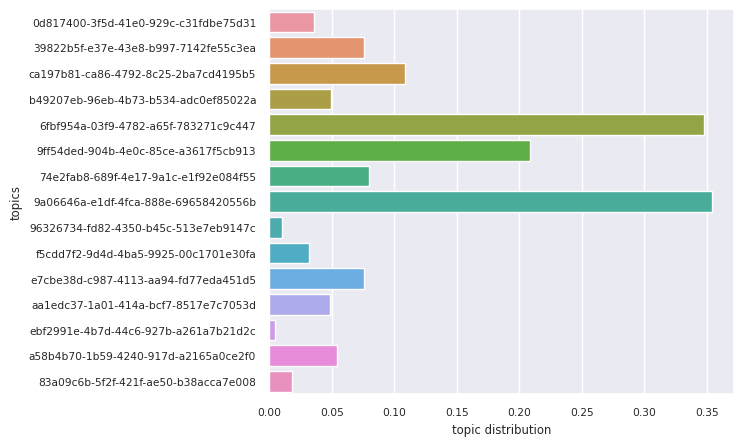

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale=0.7)
f, ax = plt.subplots(figsize=(6, 5))
sns.barplot(x=temp.values, y=temp.index,
            label="Total", orient='h')
ax.set(xlabel="topic distribution", ylabel="topics")
plt.show()

In [ ]:
#Splitting the dataset
dds = ds.train_test_split(0.2)
dds

DatasetDict({
    train: Dataset({
        features: ['body', 'topic', '0d817400-3f5d-41e0-929c-c31fdbe75d31', '39822b5f-e37e-43e8-b997-7142fe55c3ea', 'ca197b81-ca86-4792-8c25-2ba7cd4195b5', 'b49207eb-96eb-4b73-b534-adc0ef85022a', '6fbf954a-03f9-4782-a65f-783271c9c447', '9ff54ded-904b-4e0c-85ce-a3617f5cb913', '74e2fab8-689f-4e17-9a1c-e1f92e084f55', '9a06646a-e1df-4fca-888e-69658420556b', '96326734-fd82-4350-b45c-513e7eb9147c', 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa', 'e7cbe38d-c987-4113-aa94-fd77eda451d5', 'aa1edc37-1a01-414a-bcf7-8517e7c7053d', 'ebf2991e-4b7d-44c6-927b-a261a7b21d2c', 'a58b4b70-1b59-4240-917d-a2165a0ce2f0', '83a09c6b-5f2f-421f-ae50-b38acca7e008'],
        num_rows: 4121
    })
    test: Dataset({
        features: ['body', 'topic', '0d817400-3f5d-41e0-929c-c31fdbe75d31', '39822b5f-e37e-43e8-b997-7142fe55c3ea', 'ca197b81-ca86-4792-8c25-2ba7cd4195b5', 'b49207eb-96eb-4b73-b534-adc0ef85022a', '6fbf954a-03f9-4782-a65f-783271c9c447', '9ff54ded-904b-4e0c-85ce-a3617f5cb913', '7

# Tokenizing

In [ ]:
#mapping labels to integers and back
labels = topics
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
id2label

{0: '0d817400-3f5d-41e0-929c-c31fdbe75d31',
 1: '39822b5f-e37e-43e8-b997-7142fe55c3ea',
 2: 'ca197b81-ca86-4792-8c25-2ba7cd4195b5',
 3: 'b49207eb-96eb-4b73-b534-adc0ef85022a',
 4: '6fbf954a-03f9-4782-a65f-783271c9c447',
 5: '9ff54ded-904b-4e0c-85ce-a3617f5cb913',
 6: '74e2fab8-689f-4e17-9a1c-e1f92e084f55',
 7: '9a06646a-e1df-4fca-888e-69658420556b',
 8: '96326734-fd82-4350-b45c-513e7eb9147c',
 9: 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa',
 10: 'e7cbe38d-c987-4113-aa94-fd77eda451d5',
 11: 'aa1edc37-1a01-414a-bcf7-8517e7c7053d',
 12: 'ebf2991e-4b7d-44c6-927b-a261a7b21d2c',
 13: 'a58b4b70-1b59-4240-917d-a2165a0ce2f0',
 14: '83a09c6b-5f2f-421f-ae50-b38acca7e008'}

In [ ]:
model_nm = "bert-base-uncased"

In [ ]:
#loads the appropriate tokenizer based on the checkpoint on the hub
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
tokenizer.tokenize("Hi, My name is Sahar.")

['hi', ',', 'my', 'name', 'is', 'sa', '##har', '.']

In [ ]:
#creating the labels needed to give to our model (a matrix of shape (batch_size, num_labels))
def preprocess_data(examples):
  # take a batch of texts
  text = examples["body"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [ ]:
encoded_dataset = dds.map(preprocess_data, batched=True, remove_columns=dds['train'].column_names)

Map:   0%|          | 0/4121 [00:00<?, ? examples/s]

Map:   0%|          | 0/1031 [00:00<?, ? examples/s]

In [ ]:
example = encoded_dataset['train'][0]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])


In [ ]:
tokenizer.decode(example['input_ids'])

"[CLS] leviathan. it's been 24 hours since the russian military began a full scale invasion into ukraine. a bombardment of airstrikes attacked targets all over the large country as russian troops crossed the border from the north, the east and the south. as you can see here from this map, the attacks are not just happening in an isolated area. they're all across the large country. ukraine's president vlottamir zelensky saying at least 137 people are dead tonight and 316 others are wounded. 74 ukrainian military facilities have been destroyed. that includes eleven airbases. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]"

In [ ]:
example['labels']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
[id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0]

['9a06646a-e1df-4fca-888e-69658420556b']

In [ ]:
#setting the format of our data to pytorch tensors
encoded_dataset.set_format("torch")

#  Defining the model and setting params


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_nm, 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
bs = 16
lr = 5e-5
epochs = 12
metric_name = "f1"

In [ ]:
args = TrainingArguments(
    f"bert-finetuned-topic_modeling",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=lr,
    lr_scheduler_type='cosine',
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [ ]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Applying sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Using threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    #computing the metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
encoded_dataset['train'][0]['labels'].type()

'torch.FloatTensor'

In [ ]:
encoded_dataset['train']['input_ids'][0]

tensor([  101,  4067,  2017,  1010,  5863,  1012,  2085,  2057,  1005,  2128,
         2183,  2000,  2735,  2000,  1996,  6745,  2006,  1996,  5325,  2007,
         3607,  2058,  5924,  1012,  1996,  2149, 12771,  1037,  5337,  2517,
         3433,  2000,  2845,  7670,  2004,  2009,  3138,  1996,  5761,  2000,
         8945, 29576, 10079,  6956,  1999,  5924,  1005,  1055,  2510,  1012,
         2256,  3026,  3097, 11370,  4775,  5997,  2003,  1999,  5924,  1012,
         2204,  2851,  1010,  4775,  1012,  3398,  1010,  2204,  2851,  1010,
         2745,  1012,  2845,  2343,  8748, 22072,  2038,  2085,  3273,  2637,
         1005,  1055,  3433,  2006,  1996,  3036,  3314,  1012,  1996,  1047,
        28578,  4115,  3038,  2023,  2851,  2008,  4924,  1005,  1055,  2440,
         3433,  2097,  2022,  9170,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0), labels=encoded_dataset['train'][0]['labels'].unsqueeze(0))
outputs

SequenceClassifierOutput(loss=tensor(0.7291, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[-0.4677,  0.3675,  0.4447, -0.3659, -0.3138,  0.4962,  0.3212,  0.4627,
         -0.1064, -0.8340, -0.5657,  0.4725,  0.0333,  0.1030,  0.5976]],
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.159075,0.669535,0.770418,0.400582
2,0.190100,0.130444,0.752364,0.837775,0.496605
3,0.190100,0.128395,0.750346,0.840385,0.495635
4,0.092600,0.133844,0.743528,0.837340,0.494665
5,0.092600,0.137840,0.742001,0.840522,0.477207
6,0.051200,0.146526,0.747595,0.851005,0.483026
7,0.051200,0.147835,0.756739,0.854945,0.498545
8,0.027600,0.151331,0.752964,0.855980,0.488846
9,0.027600,0.152192,0.753556,0.855015,0.490786
10,0.018000,0.153424,0.757686,0.857449,0.496605


TrainOutput(global_step=3096, training_loss=0.0642052002886469, metrics={'train_runtime': 1320.8763, 'train_samples_per_second': 37.439, 'train_steps_per_second': 2.344, 'total_flos': 3253221654838272.0, 'train_loss': 0.0642052002886469, 'epoch': 12.0})

# Evaluate our model

In [ ]:
trainer.evaluate()

{'eval_loss': 0.15342380106449127,
 'eval_f1': 0.7576859504132231,
 'eval_roc_auc': 0.8574494317040875,
 'eval_accuracy': 0.49660523763336567,
 'eval_runtime': 7.3584,
 'eval_samples_per_second': 140.113,
 'eval_steps_per_second': 4.485,
 'epoch': 12.0}

# Saving our *model*

In [ ]:
trainer.save_model(config.MODEL_DIR / 'bert_topic_modeling')

# loading our model and inference

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(config.MODEL_DIR / "bert_topic_modeling")
trainer = Trainer(model, tokenizer=tokenizer)

In [ ]:
test_df = pd.read_csv(config.DATA_DIR / "filled.csv")
test_df.head(3)

,Unnamed: 0,first_words,last_words,source_video_id,start,end,body
0,0,Well knew. This morning police need your help,"gunpoint, beating him and stealing his cell phone.",18246,464928,504300,"Well knew. This morning police need your help finding the group behind a string of violent robberies in the Bronx. Investigators are looking for the five suspects you see in these surveillance images. And they say two of the incidents happened just minutes apart on August 18. The first near Olenville Avenue and Waits Place. That's where five people beat a man before stealing his iPhone. Five minutes later, just before midnight, the same group attacked a 47 year old man on Brocks Park East, stealing his backpack. And police say in a third robbery on August 29 at the same location, the suspects robbed a man at gunpoint, beating him and stealing his cell phone."
1,1,a call. San Francisco firefighters rescued a man,all the way down to the ocean.,12387,359020,384950,"a call. San Francisco firefighters rescued a man right near the Cliff house. They say he fell over this ledge here early this morning. If you're not familiar with the area, this is kind of just north end of Ocean Beach. You could see the firefighters. They're able to use their ropes and pull that man up about 20ft from the cement barrier down below. Now they say it could have been much worse. It was just about a foot or two away from going even farther down below, all the way down to the ocean."
2,2,"Paul. Meanwhile, the state set a record in","night through conservation, some 4000 conservation is extraordinary.",16859,60704,100410,"Paul. Meanwhile, the state set a record in energy demand yesterday at 52,061 isn't too far behind. We were, however, able to narrowly avoid rolling blackouts. State energy officials and governor newsom are crediting Californians for cutting back just enough yesterday to keep the grid from getting. Overwhelmed over the next two days. We're still going to have to be mindful of work yet to be done. That said, what folks were able to accomplish last night through conservation, some 4000 conservation is extraordinary."


In [ ]:
def test_model(text):
  encoding = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
  encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
  outputs = trainer.model(**encoding)
  logits = outputs.logits
  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(logits.squeeze().cpu())
  predictions = np.zeros(probs.shape)
  predictions[np.where(probs >= 0.5)] = 1
  predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
  return str(predicted_labels)

In [ ]:
test_df.loc[4, "body"]

"But even though the state never ordered rolling blackouts, some bay area neighborhoods did see their power cut. Hillsborough, Alameda and Palo Alto all shut off power to some customers. Kpxy. Sarah Dante is live in Alameda. Explain why officials in those cities say it's not their fault. A lot of finger pointing happening here today. Ryan with this story. So again, those rolling blackouts that happened, it turns out all of those were a mistake. A very costly, in some cases uncomfortable mistake. And we spent much of the day trying to figure out exactly what went wrong. Running a restaurant in the dark isn't just difficult, it's impossible. Just ask Stephanie. We can't take any card we don't have ride inside. So it's all dot her Alameda restaurant had the power cut off during its typically busy dinner hour, forcing them to close early. Customers were told it was part of a rolling blackout, but now it appears that was a mistake. Crazy. And we lost some more money. Yeah, that's it. Alamed

In [ ]:
test_model(test_df.loc[4, "body"])

"['9a06646a-e1df-4fca-888e-69658420556b', 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa']"

In [ ]:
test_df["topic"] = test_df["body"].apply(lambda row: test_model(row))
test_df.head(3)

,Unnamed: 0,first_words,last_words,source_video_id,start,end,body,topic
0,0,Well knew. This morning police need your help,"gunpoint, beating him and stealing his cell phone.",18246,464928,504300,"Well knew. This morning police need your help finding the group behind a string of violent robberies in the Bronx. Investigators are looking for the five suspects you see in these surveillance images. And they say two of the incidents happened just minutes apart on August 18. The first near Olenville Avenue and Waits Place. That's where five people beat a man before stealing his iPhone. Five minutes later, just before midnight, the same group attacked a 47 year old man on Brocks Park East, stealing his backpack. And police say in a third robbery on August 29 at the same location, the suspects robbed a man at gunpoint, beating him and stealing his cell phone.",['9a06646a-e1df-4fca-888e-69658420556b']
1,1,a call. San Francisco firefighters rescued a man,all the way down to the ocean.,12387,359020,384950,"a call. San Francisco firefighters rescued a man right near the Cliff house. They say he fell over this ledge here early this morning. If you're not familiar with the area, this is kind of just north end of Ocean Beach. You could see the firefighters. They're able to use their ropes and pull that man up about 20ft from the cement barrier down below. Now they say it could have been much worse. It was just about a foot or two away from going even farther down below, all the way down to the ocean.",['9a06646a-e1df-4fca-888e-69658420556b']
2,2,"Paul. Meanwhile, the state set a record in","night through conservation, some 4000 conservation is extraordinary.",16859,60704,100410,"Paul. Meanwhile, the state set a record in energy demand yesterday at 52,061 isn't too far behind. We were, however, able to narrowly avoid rolling blackouts. State energy officials and governor newsom are crediting Californians for cutting back just enough yesterday to keep the grid from getting. Overwhelmed over the next two days. We're still going to have to be mindful of work yet to be done. That said, what folks were able to accomplish last night through conservation, some 4000 conservation is extraordinary.","['39822b5f-e37e-43e8-b997-7142fe55c3ea', 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa']"


In [ ]:
inference("Paul. Meanwhile, the state set a record in energy demand yesterday at 52,061 isn't too far behind. We were, however, able to narrowly avoid rolling blackouts. State energy officials and governor newsom are crediting Californians for cutting back just enough yesterday to keep the grid from getting. Overwhelmed over the next two days. We're still going to have to be mindful of work yet to be done. That said, what folks were able to accomplish last night through conservation, some 4000 conservation is extraordinary.")

"['39822b5f-e37e-43e8-b997-7142fe55c3ea', 'f5cdd7f2-9d4d-4ba5-9925-00c1701e30fa']"